# Exponential weights and window features

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we demonstrate how to compute exponential weights for both rolling and expanding window features using Pandas.


## Data set synopsis


We will work with the hourly electricity demand dataset. It is the electricity demand for the state of Victora in Australia from 2002 to the start of 2015. 

For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

In [3]:
# For this demo we will use a subset of the data
data = data.loc["2010":]

In [4]:
data.head()

,demand,temperature
date_time,,
2010-01-01 00:00:00,8314.448682,21.525
2010-01-01 01:00:00,8267.187296,22.400
2010-01-01 02:00:00,7394.528444,22.150
2010-01-01 03:00:00,6952.047520,21.800
2010-01-01 04:00:00,6867.199634,20.250


# Computing exponential weights for rolling window features using Pandas

When using exponential weights it is more common to use expanding windows, but we will show how to use exponential weights with rolling windows for completeness. It will also come in handy when we want to compute custom metrics.

In [5]:
# Create a copy of the data.
df = data.copy()

Let's create a function that computes exponential weights for an input window size and `alpha` parameter.

The weights should be: \[(1-$\alpha)^{(W-1)}$, ... ,(1-$\alpha)^2$, (1-$\alpha)$, 1\] where $W$ is the window size.

In [6]:
# Compute exponential weights
def exp_weights(alpha, window_size):
    weights = np.ones(window_size) # Initialise weights
    for ix in range(window_size):
        weights[ix] = (1-alpha)**(window_size-1-ix)
    return weights

In [7]:
# Check it works
exp_weights(alpha=0.05, window_size=12)

array([0.56880009, 0.59873694, 0.63024941, 0.66342043, 0.6983373 ,
       0.73509189, 0.77378094, 0.81450625, 0.857375  , 0.9025    ,
       0.95      , 1.        ])

In [8]:
# Double check the second term
print((1-0.05) * 0.95)

0.9025


In [9]:
# Define our own weighted mean function to pass to `agg`
def exp_weighted_mean(x):
    weights = exp_weights(alpha=0.05, window_size=len(x))
    return (weights * x).sum() / weights.sum()

Let's compute the rolling window features!

In [10]:
result = (
    df["demand"]
    .rolling(window=24*7) # Pick window size.
    .agg(["mean", exp_weighted_mean]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.  
)
result = result.add_prefix("demand_window_168_")

result

,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,
2010-01-01 01:00:00,NaN,NaN
2010-01-01 02:00:00,NaN,NaN
2010-01-01 03:00:00,NaN,NaN
2010-01-01 04:00:00,NaN,NaN
2010-01-01 05:00:00,NaN,NaN
...,...,...
2015-02-28 20:00:00,9654.616819,9270.767464
2015-02-28 21:00:00,9638.018555,9251.365371
2015-02-28 22:00:00,9624.108291,9204.788983


Let's join this back to the original dataframe.

In [11]:
df = df.join(result, how="left")
df

,demand,temperature,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,NaN,NaN
2010-01-01 02:00:00,7394.528444,22.150,NaN,NaN
2010-01-01 03:00:00,6952.047520,21.800,NaN,NaN
2010-01-01 04:00:00,6867.199634,20.250,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9670.463454,9253.634423
2015-02-28 20:00:00,8883.230296,22.200,9654.616819,9270.767464
2015-02-28 21:00:00,8320.260550,18.900,9638.018555,9251.365371


Text(0.5, 0, 'Time')

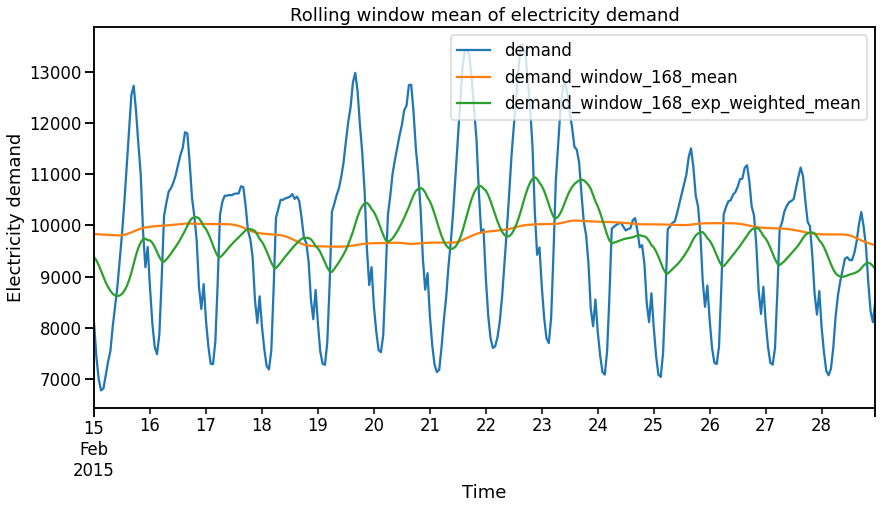

In [12]:
cols = ["demand",
        "demand_window_168_mean",
        "demand_window_168_exp_weighted_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
      .loc[:, cols] # Filter to columns of interest
      .plot(figsize=[14, 7])
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

The rolling mean with exponential weights is a lot more sensitive to changes in the original data because there is a lot more weight given to recent data points. This means that the daily seasonality causes the exponentially weighted data to oscillate.

Overall, we can see the weighted mean moves more quickly in response to changing trends in the data.

If we want to use the weighted window functions to be more responsive to short term **trends** then de-seasonalising the data first may be helpful. Let's try this and see what happens.

# Smoothing the data after de-trending

As there is multiple seasonal components we shall use MSTL to de-seasonalise the data.

In [13]:
from statsmodels.tsa.seasonal import MSTL

In [14]:
# Let's extract only the trend component
mstl = MSTL(df["demand"], 
            periods=(24, 24 * 7), # Remove daily and weekly seasonality
            stl_kwargs={"seasonal_deg": 0})
res = mstl.fit()

We're leaving in yearly seasonality because it would take a long time to compute and also our window size is on a much smaller scale (i.e., that of one week).

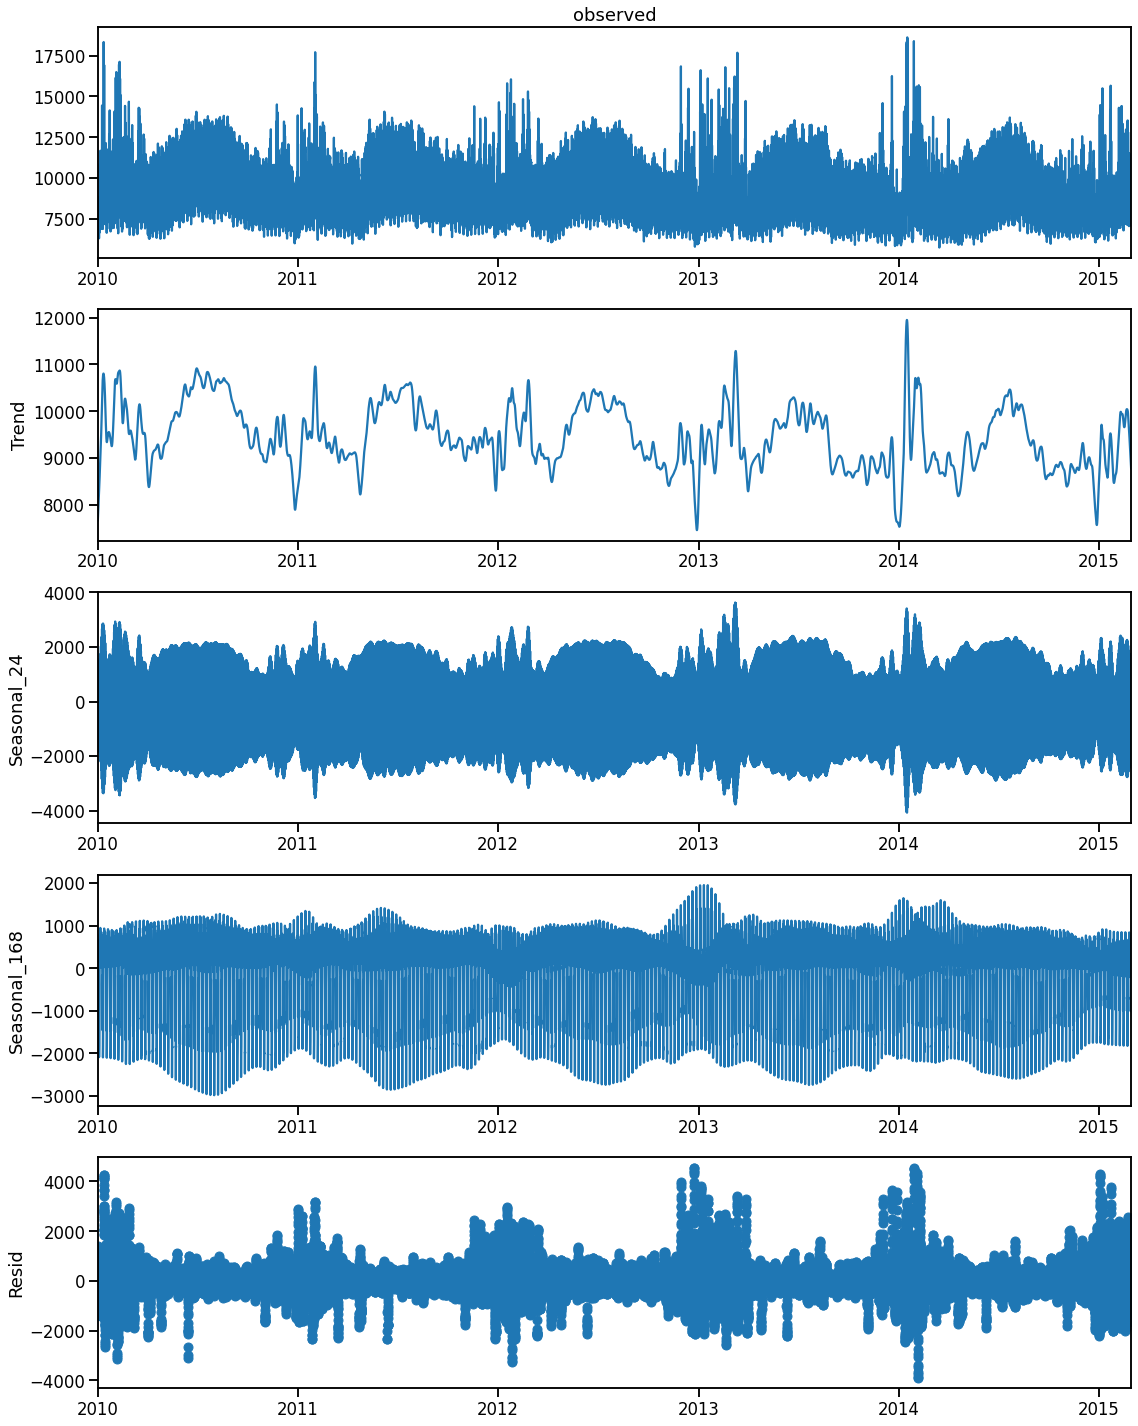

In [15]:
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

In [16]:
result = (
    res.trend # The trend component from MSTL.
    .rolling(window=24*7) # Pick window size.
    .agg(["mean", exp_weighted_mean]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.  
)

result = result.add_prefix("demand_window_168_")

# Join the window features back to the trend data
df = res.trend.to_frame().join(result, how='left')
df

,trend,demand_window_168_mean,demand_window_168_exp_weighted_mean
date_time,,,
2010-01-01 00:00:00,7672.016455,NaN,NaN
2010-01-01 01:00:00,7683.091900,NaN,NaN
2010-01-01 02:00:00,7694.177071,NaN,NaN
2010-01-01 03:00:00,7705.272092,NaN,NaN
2010-01-01 04:00:00,7716.377060,NaN,NaN
...,...,...,...
2015-02-28 19:00:00,8817.785857,9541.062328,8999.626058
2015-02-28 20:00:00,8808.736317,9533.775910,8990.522970
2015-02-28 21:00:00,8799.694076,9526.439463,8981.422484


Text(0.5, 0, 'Time')

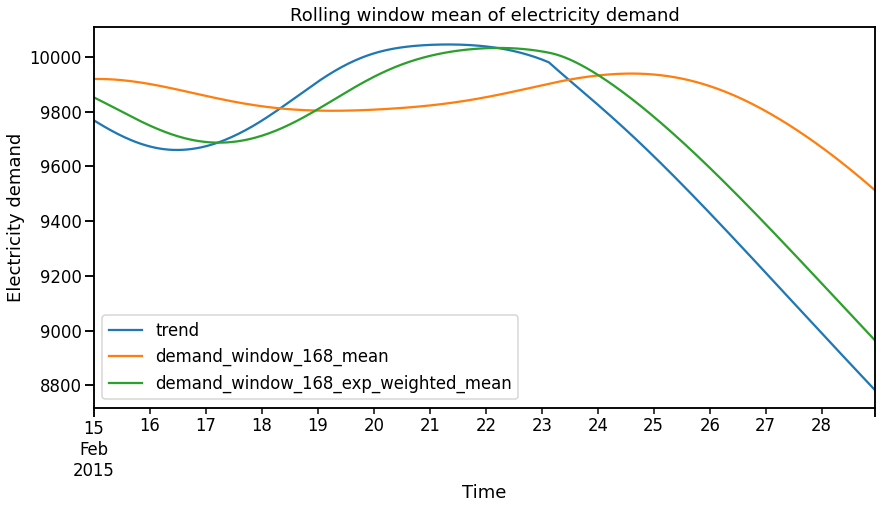

In [17]:
cols = ["trend",
        "demand_window_168_mean",
        "demand_window_168_exp_weighted_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
      .loc[:, cols] # Filter to columns of interest
      .plot(figsize=[14, 7])
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("Time")

The exponentially weighted window mean clearly responds faster to the changing trend relative to the non-weighted window mean.

# Computing expanding windows features with exponential weights using Pandas

In [18]:
# Create a copy of the data.
df = data.copy()

We want to compute with exponential weights the expanding:
- mean
- standard deviation

As the weights are computed internally in Pandas when using the `ewm` (exponentially weighted moving) method we cannot pass custom functions.

In [19]:
result = (
    df["demand"]
    .ewm(alpha=0.05) # Set `alpha`, use `ewm` rather than `rolling`
    .agg(["mean", "std"]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage." 
        )
result = result.add_prefix("demand_ewm_0.05_")

result

,demand_ewm_0.05_mean,demand_ewm_0.05_std
date_time,,
2010-01-01 01:00:00,8314.448682,NaN
2010-01-01 02:00:00,8290.212074,33.418847
2010-01-01 03:00:00,7976.212554,524.172887
2010-01-01 04:00:00,7700.147988,673.871614
2010-01-01 05:00:00,7516.045829,693.695185
...,...,...
2015-02-28 20:00:00,9271.029970,1083.173746
2015-02-28 21:00:00,9251.639986,1059.213642
2015-02-28 22:00:00,9205.071014,1052.675596


Let's join this back to the original dataframe.

In [20]:
df = df.join(result, how="left")
df

,demand,temperature,demand_ewm_0.05_mean,demand_ewm_0.05_std
date_time,,,,
2010-01-01 00:00:00,8314.448682,21.525,NaN,NaN
2010-01-01 01:00:00,8267.187296,22.400,8314.448682,NaN
2010-01-01 02:00:00,7394.528444,22.150,8290.212074,33.418847
2010-01-01 03:00:00,6952.047520,21.800,7976.212554,524.172887
2010-01-01 04:00:00,6867.199634,20.250,7700.147988,673.871614
...,...,...,...,...
2015-02-28 19:00:00,9596.777060,28.350,9253.885386,1108.594937
2015-02-28 20:00:00,8883.230296,22.200,9271.029970,1083.173746
2015-02-28 21:00:00,8320.260550,18.900,9251.639986,1059.213642


# Custom metrics

If we want to compute custom metrics with exponential weights and an expanding window, we can use `expanding`. Let's illustrate this by manually implementing the expanding mean with exponential weights.

In [21]:
# Define our own weighted mean function to pass to `agg`
def exp_weighted_mean(x):
    weights = exp_weights(alpha=0.05, window_size=len(x))
    return (weights * x).sum() / weights.sum()

In [22]:
result = (
    df["demand"]
    .tail(1000) # Using a subset of data as this is very slow to run.
    .expanding() # Use `expanding` rather than `ewm`.
    .agg([exp_weighted_mean]) # Pass a function which computes the weights as the window expands.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage." 
        )
result = result.add_prefix("demand_ewm_0.05_")

result

,demand_ewm_0.05_exp_weighted_mean
date_time,
2015-01-18 09:00:00,7111.467232
2015-01-18 10:00:00,7248.486864
2015-01-18 11:00:00,7308.361980
2015-01-18 12:00:00,7344.778785
2015-01-18 13:00:00,7344.848298
...,...
2015-02-28 20:00:00,9271.029970
2015-02-28 21:00:00,9251.639986
2015-02-28 22:00:00,9205.071014


So now we've shown how to create expanding and rolling window features using exponential weights.